# Protein Family Classification

## Task
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you

In [26]:
import os
import joblib
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from lazy import lazy
from sklearn.svm import SVC
from attrdict import AttrDict
from tqdm import tqdm_notebook
from collections import Counter, defaultdict
from keras.preprocessing.sequence import pad_sequences

## Data Reading

In [2]:
data_df = pd.read_table('../seminar05/data/family_classification_metadata.tab')
seq_df = pd.read_table('../seminar05/data/family_classification_sequences.tab')
vec_df = pd.read_csv('protVec_100d_3grams.csv', header=None)

In [3]:
len(data_df), (len(data_df) == len(seq_df))

(324018, True)

In [4]:
data_df.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [5]:
data_df.describe()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
count,324018,324018,324018,324018,324018
unique,287308,295671,56951,7027,6967
top,Q1X881,POLG_DEN2N,UvrABC system protein B,MMR_HSR1,50S ribosome-binding GTPase
freq,16,12,1500,3084,3084


In [6]:
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [7]:
vec_df.head()

,0
0,AAA\t-0.17406\t-0.095756\t0.059515\t0.039673\t...
1,ALA\t-0.114085\t-0.093288\t0.1558\t-0.037351\t...
2,LLL\t-0.075594\t-0.100834\t-0.046616\t-0.20898...
3,LAA\t-0.137546\t-0.135425\t0.121566\t-0.038295...
4,AAL\t-0.156112\t-0.133524\t0.114426\t-0.020264...


## Data Processing

In [8]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq
    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]


def create_codone2vec():
    return {row[1][0].split('\t', maxsplit=1)[0]: np.array(list(map(float, row[1][0].split('\t')[1:])))
            for row in vec_df.iterrows()}


def create_data(top_classes):
    # familty <-> num
    families = data_df['FamilyID']
    family2num = {c: i for i, (c, _) in enumerate(Counter(families).most_common(top_classes))}
    num2family = {i: c for c, i in family2num.items()}
    # good indicies
    inds = np.array([i for i, f in enumerate(families) if f in family2num])
    # codone -> vec | <unk>
    codone2vec = create_codone2vec()
    # codone <-> num
    codones = set(codone2vec.keys())
    codone2num = {c: i for i, (c, _) in enumerate(Counter(codones).most_common())}
    codone2num = defaultdict(lambda: codone2num['<unk>'], codone2num)
    num2codone = {i: c for c, i in codone2num.items()}
    # num -> vec
    num2vec = {i: codone2vec[c] for c, i in codone2num.items()}
    
    X, y = [], []
    for i, (row,) in tqdm_notebook(seq_df.iloc[inds].iterrows(), total=len(inds)):
        X.append(np.array([codone2num[x] for x in make_codones(row)]))
        y.append(family2num[families[i]])
    
    return X, np.array(y), num2vec, num2family

In [9]:
def read_or_create(read_path, refresh, producer, saver):
    if os.path.isfile(read_path) and not refresh:
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return saver.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        saver.dump(result, fp)
    return result


def process_data(read_path, refresh, top_classes, saver=pickle):
    return read_or_create(read_path=read_path, 
                          refresh=refresh,
                          producer=lambda: create_data(top_classes=top_classes), 
                          saver=saver)

In [10]:
raw_X, raw_Y, num2vec, num2family = process_data(read_path='raw_data.pickle', 
                                                 refresh=False, top_classes=100)

reading raw_data.pickle


## Examine Data

So far, we have only `raw_X`, `raw_Y`, `num2vec` and `num2family` to work with.

In [11]:
type(raw_X), len(raw_X), type(raw_X[0]), raw_X[0].shape, max(x.shape[0] for x in raw_X)

(list, 95519, numpy.ndarray, (316,), 3429)

In [12]:
type(raw_Y), raw_Y.shape, raw_Y.min(), raw_Y.max()

(numpy.ndarray, (95519,), 0, 99)

In [13]:
type(num2vec), list((n, v.shape) for n, v in num2vec.items())[:4]

(dict, [(0, (100,)), (1, (100,)), (2, (100,)), (3, (100,))])

In [14]:
type(num2family), list(num2family.items())[:4]

(dict, [(0, 'MMR_HSR1'), (1, 'Helicase_C'), (2, 'ATP-synt_ab'), (3, '7tm_1')])

In [15]:
def processess_simple(X, Y, n2v):
    # shuffling
    arr = np.arange(len(X))
    np.random.shuffle(arr)
    X, Y = pd.Series(X).iloc[arr].tolist(), Y[arr]
    # ...
    return np.vstack([np.mean(np.vstack([n2v[int(c)] for c in x]), axis=0) for x in X]), Y

In [16]:
def preprocess_batched(X, Y, n2v, params):
    # shuffling
    arr = np.arange(len(X))
    np.random.shuffle(arr)
    X, Y = pd.Series(X).iloc[arr].tolist(), Y[arr]
    # generator
    it_X, it_Y = iter(X), iter(Y)
    while True:
        data = np.zeros((params.batch_size, params.seq_length, params.embed_length))
        target = np.zeros((params.batch_size, params.classes))
        for index in range(params.batch_size):
            x, y = next(it_X), next(it_Y)
            seq = np.zeros((params.seq_length, params.embed_length))
            seq[:len(x)] = np.vstack([n2v[int(n)] for n in x])
            data[index] = seq
            label = np.zeros(params.classes)
            label[y] = 1
            target[index] = label
        yield data, target

## Model

In [29]:
class FamilyClassifierRNNModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    @lazy
    def prediction(self):
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)
        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal([self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @lazy
    def length(self):
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, self.params.classes])
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])
            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

## Evaluating

In [43]:
params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=100,
    optimizer=tf.train.RMSPropOptimizer(0.005),
    batch_size=128,
    gradient_clipping=100,
    seq_length=max(x.shape[0] for x in raw_X),
    embed_length=num2vec[0].shape[0],
    classes=raw_Y.max() + 1,
    device='gpu',
    mem_frac=0.333,
    max_iter=None,
    test_size=0.2
)
params

AttrDict({'rnn_cell': <class 'tensorflow.contrib.rnn.python.ops.core_rnn_cell_impl.GRUCell'>, 'rnn_hidden': 100, 'optimizer': <tensorflow.python.training.rmsprop.RMSPropOptimizer object at 0x7f864bf47d30>, 'batch_size': 128, 'gradient_clipping': 100, 'seq_length': 3429, 'embed_length': 100, 'classes': 100, 'device': 'gpu', 'mem_frac': 0.333, 'max_iter': None, 'test_size': 0.2})

In [44]:
def get_total(mode):
    scale = (1 - params.test_size) if mode == "train" else params.test_size
    return min(int(len(raw_X) * scale / params.batch_size), 
               params.max_iter or len(raw_X))

In [45]:
raw_X_train, raw_X_test, raw_Y_train, raw_Y_test = train_test_split(raw_X, raw_Y, test_size=params.test_size) 
train_batches = preprocess_batched(raw_X_train, raw_Y_train, num2vec, params)
test_batches = preprocess_batched(raw_X_test, raw_Y_test, num2vec, params)

In [46]:
tf.reset_default_graph()
model = FamilyClassifierRNNModel(params)

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [47]:
if params.device == 'cpu':
    config = tf.ConfigProto(device_count={'GPU': 0})
else:
    config = tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=params.mem_frac))

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter('graphs', sess.graph)
    error = 1.
    loss = float('inf')
    with tqdm_notebook(total=get_total('train')) as pbar:
        for index, batch in enumerate(train_batches):
            pbar.update(1)
            pbar.set_description('train error at {}: {:3.3f}%, loss: {:3.3f}, batches passed'
                                 .format(index + 1, 100 * error, loss))
            if index == params.max_iter: break
            feed = {model.data: batch[0], model.target: batch[1]}
            error, _, summary_str, loss = sess.run([model.error, model.optimize, model.summary, model.cost], feed)
            summary_writer.add_summary(summary_str, index)
    
    total_error = 0.
    its = 0
    with tqdm_notebook(total=get_total('test')) as pbar:
        for index, batch in enumerate(test_batches):
            pbar.update(1)
            pbar.set_description('test error at {}: {:3.3f}%, batches passed'
                                 .format(index + 1, 100 * error))
            if index == params.max_iter: break
            feed = {model.data: batch[0], model.target: batch[1]}
            error = sess.run(model.error, feed)
            total_error += error
            its += 1
    
    print('Acc: {}'.format(1 - (total_error / its)))

A Jupyter Widget

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: generator 'preprocess_batched' raised StopIteration
  if sys.path[0] == '':


A Jupyter Widget


Acc: 0.8056312919463087


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: generator 'preprocess_batched' raised StopIteration


## Baseline

In [17]:
X, Y = processess_simple(raw_X, raw_Y, num2vec)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=params.test_size) 

In [21]:
# model = SVC()
model = RandomForestClassifier()
model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
'Acc: {}'.format((model.predict(X_test) == Y_test).sum() / len(X_test))

'Acc: 0.6849350921273032'

## TSNE

In [27]:
tsne = TSNE(n_components=2)
inds = ((Y == 0) | (Y == 1)).squeeze()
emb_X, emb_Y = tsne.fit_transform(X[inds]), Y[inds]

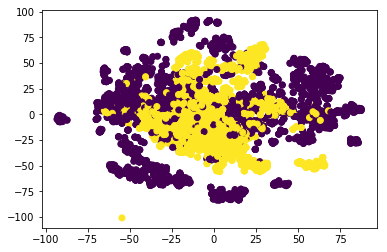

In [28]:
plt.scatter(emb_X[:, 0], emb_X[:, 1], c=emb_Y)
plt.show()